In [1]:
import pylab as pl
import pandas as pd
import numpy as np
#imports downloader
import scipy.stats


from __future__ import print_function, division

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

import statsmodels.api as sm
import statsmodels.formula.api as smf


%pylab inline
import json
import os, shutil
import sys
import requests

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Read in data
TXdata = pd.read_csv("https://stacks.stanford.edu/file/druid:py883nd2578/TX-clean.csv.gz", index_col = None, compression = 'gzip')

/nfshome/jtl417/.conda/envs/MLPythonKernel/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,16,19,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## Drop columns not needed

TXdataTrim = TXdata.drop([u'state', u'county_fips', u'fine_grained_location', 
       u'police_department', u'driver_gender', u'driver_age_raw',
       u'driver_age', u'violation_raw',
       u'violation', u'lat', u'lon',
       u'officer_id'], axis=1)

In [4]:
#Group data by county, driver race and whether or not a search was conducted

TXcrs = TXdataTrim.groupby(['county_name', 'driver_race','search_conducted']).count()

In [5]:
## Drop columns not needed

TXcrs.drop([u'stop_date', u'stop_time', u'location_raw', u'driver_race_raw',
       u'search_type_raw', u'search_type', u'contraband_found',
       u'stop_outcome', u'is_arrested', u'driver_race_original'],axis=1, inplace=True)

In [6]:
#For ease of debugging, make copy of initial dataset

TXsearch = TXcrs

In [7]:
#Dataframe for stops where search was conducted (for outcome test)

TXcontraband = TXdataTrim[TXdataTrim.search_conducted == True] 
TXcontraband = TXcontraband.groupby(['county_name', 'driver_race','contraband_found']).count()
TXcontraband.drop([u'stop_date', u'stop_time', u'location_raw', u'driver_race_raw',
       u'search_type_raw', u'search_type', u'search_conducted',
       u'stop_outcome', u'is_arrested', u'driver_race_original'],axis=1, inplace=True)

In [8]:
TXcontraband.head(10)

id
county_name     driver_race contraband_found     
Anderson County Black       False             210
                            True              136
                Hispanic    False             152
                            True               77
                Other       False               2
                White       False             737
                            True              405
Andrews County  Asian       False               1
                            True                1
                Black       False              27

In [9]:
TXsearch.head(10)

id
county_name     driver_race search_conducted       
Anderson County Asian       False               638
                Black       False             18504
                            True                346
                Hispanic    False             10699
                            True                229
                Other       False               138
                            True                  2
                White       False             87781
                            True               1142
Andrews County  Asian       False               119

In [10]:
#List of counties to iterator through

counties = TXsearch.index.get_level_values(0).unique()

In [11]:
#Copy for debugging

test = TXsearch

In [12]:
#Calculate search hit rates (% of stops resulting in searches) for different racial groups across all counties in texas

blacksearchHR = {}
whitesearchHR = {}
hispanicsearchHR = {}
for county in counties:
    if len(test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & \
                            (test.index.get_level_values(2) == True)]['id']) < 1:
        blacksearchHR[county] = 0
    else:
        blacksearchHR[county] = 1-((test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & \
                                (test.index.get_level_values(2) == False)]['id'][0]) / \
        (test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & (test.index.get_level_values(2) == False)]['id'][0] + \
    test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & (test.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & \
                            (test.index.get_level_values(2) == True)]['id']) == 0:
        WhitesearchHR[county] = 0
    else:
        whitesearchHR[county] = 1-((test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & \
                                (test.index.get_level_values(2) == False)]['id'][0]) / \
        (test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & (test.index.get_level_values(2) == False)]['id'][0] + \
    test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & (test.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & \
                            (test.index.get_level_values(2) == True)]['id']) == 0:
        hispanicsearchHR[county] = 0
    else:
        hispanicsearchHR[county] = 1-((test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & \
                                (test.index.get_level_values(2) == False)]['id'][0]) / \
        (test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & (test.index.get_level_values(2) == False)]['id'][0] + \
    test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & (test.index.get_level_values(2) == True)]['id'][0]))
    

In [13]:
#Calculate contraband hit rates (% of searches resulting in contraband recovery) for different racial groups 
#across all counties in texas
blackcontrabandHR = {}
whitecontrabandHR = {}
hispaniccontrabandHR = {}
for county in counties:
    if len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1:
        blackcontrabandHR[county] = 0
    elif len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1 and\
    len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1:
        blackcontrabandHR[county] = np.nan()
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        blackcontrabandHR[county] = 1
    
    else:
        blackcontrabandHR[county] = 1-((TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                                (TXcontraband.index.get_level_values(2) == False)]['id'][0]) / \
        (TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & (TXcontraband.index.get_level_values(2) == False)]['id'][0] + \
    TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & (TXcontraband.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) == 0:
        whitecontrabandHR[county] = 0
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1) &\
    (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        whitecontrabandHR[county] = np.nan()
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        whitecontrabandHR[county] = 1
    else:
        whitecontrabandHR[county] = 1-((TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                                (TXcontraband.index.get_level_values(2) == False)]['id'][0]) / \
        (TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & (TXcontraband.index.get_level_values(2) == False)]['id'][0] + \
    TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & (TXcontraband.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) == 0:
        hispaniccontrabandHR[county] = 0
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1) &\
    (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        hispaniccontrabandHR[county] = np.nan()
        
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        blackcontrabandHR[county] = 1
        
    else:
        hispaniccontrabandHR[county] = 1-((TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                                (TXcontraband.index.get_level_values(2) == False)]['id'][0]) / \
        (TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & (TXcontraband.index.get_level_values(2) == False)]['id'][0] + \
    TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & (TXcontraband.index.get_level_values(2) == True)]['id'][0]))
    

In [14]:
AsiancontrabandHR = {}
for county in counties:
    if len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Asian') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1:
        AsiancontrabandHR[county] = 0
    elif len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Asian') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1 and\
    len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Asian') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1:
        AsiancontrabandHR[county] = np.nan()
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Asian') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        AsiancontrabandHR[county] = 1
    
    else:
        AsiancontrabandHR[county] = 1-((TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Asian') & \
                                (TXcontraband.index.get_level_values(2) == False)]['id'][0]) / \
        (TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Asian') & (TXcontraband.index.get_level_values(2) == False)]['id'][0] + \
    TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Asian') & (TXcontraband.index.get_level_values(2) == True)]['id'][0]))
    

In [15]:
AsiansearchHR = {}
for county in counties:
    if len(test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Asian') & \
                            (test.index.get_level_values(2) == True)]['id']) < 1:
        AsiansearchHR[county] = 0
    else:
        AsiansearchHR[county] = 1-((test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Asian') & \
                                (test.index.get_level_values(2) == False)]['id'][0]) / \
        (test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Asian') & (test.index.get_level_values(2) == False)]['id'][0] + \
    test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Asian') & (test.index.get_level_values(2) == True)]['id'][0]))

In [16]:
#Create array of hit rate values for plotting

bcHRvals = np.asarray(list(blackcontrabandHR.values()))
wcHRvals = np.asarray(list(whitecontrabandHR.values()))
hcHRvals = np.asarray(list(hispaniccontrabandHR.values()))
bsHRvals = np.asarray(list(blacksearchHR.values()))
wsHRvals = np.asarray(list(whitesearchHR.values()))
hsHRvals = np.asarray(list(hispanicsearchHR.values()))
acHRvals = np.asarray(list(AsiancontrabandHR.values()))
asHRvals = np.asarray(list(AsiansearchHR.values()))

In [47]:
#Create size array for scaling bubbles based on the amount of searches or stops, correspondingly

sizesS = []
sizesC = []
for county in counties:
    sizesC.append((TXcontraband[TXcontraband.index.get_level_values(0) == county]['id'].sum())/40)
    sizesS.append((TXsearch[TXsearch.index.get_level_values(0) == county]['id'].sum())/1000)

Text(0.5,1,'Outcome Test: disproportionate outcomes for different racial groups based on success of searches?')

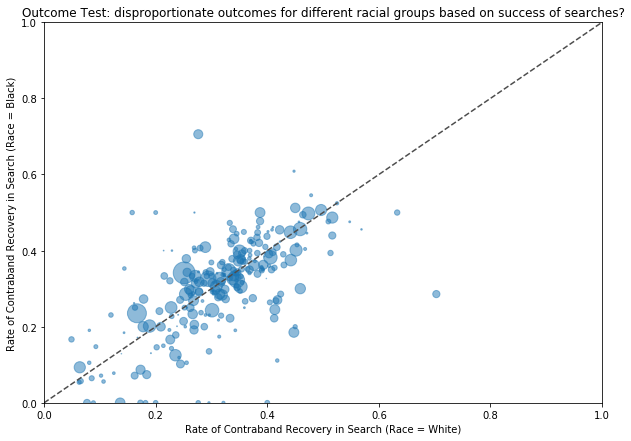

In [55]:
plt.figure(figsize=(10,7))

plt.scatter(wcHRvals, bcHRvals, alpha=.5, s=sizesC)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")

plt.xlabel("Rate of Contraband Recovery in Search (Race = White)")
plt.ylabel("Rate of Contraband Recovery in Search (Race = Black)")
plt.title("Outcome Test: disproportionate outcomes for different racial groups based on success of searches?")

Interpretation: rates of contraband recovery for black and white drivers are relatively similar across counties (points along the 45-degree dotted line have equal rates for black and white drivers). This suggests a similar risk threshold is being used for black and white drivers, as both groups have roughly equivalent hit rates within counties. While this is not conclusive (the issue of inframarginality remains: see this paper for more information https://5harad.com/papers/threshold-test.pdf) it does not present evidence of racial discriminatory practices against black drivers being searched during traffic stops in Texas.

Text(0.5,1,'Outcome Test: disproportionate outcomes for different racial groups based on success of searches?')

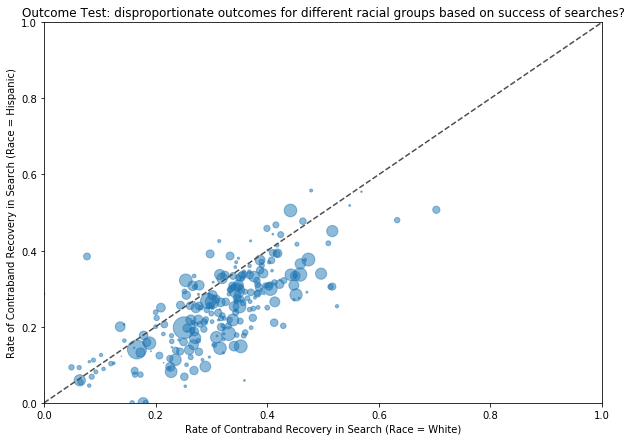

In [56]:
plt.figure(figsize=(10,7))

plt.scatter(wcHRvals, hcHRvals, alpha = .5, s=sizesC)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Contraband Recovery in Search (Race = White)")
plt.ylabel("Rate of Contraband Recovery in Search (Race = Hispanic)")
plt.title("Outcome Test: disproportionate outcomes for different racial groups based on success of searches?")

Interpretation: the rate of contraband recovered in searches of white drivers is higher than the rate for hispanic drivers in most counties, suggesting the application of a lower risk threshold when searching hispanic drivers. In other words, hispanic drivers being searched seem to have less of a chance of having contraband, suggesting empirically less risky hispanic drivers are being searched, which therefore suggests a larger presumption of criminality among hispanic drivers.

Text(0.5,1,'Benchmark Test: disproportionate rates of search for different racial groups?')

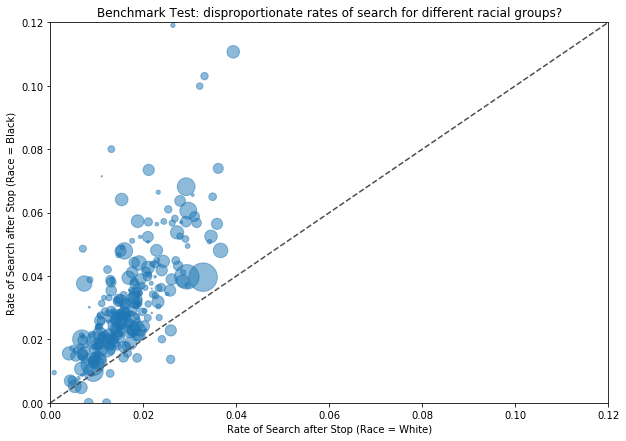

In [50]:
plt.figure(figsize=(10,7))

plt.scatter(wsHRvals, bsHRvals, alpha = .5, s=sizesS)
plt.xlim([0,.12])
plt.ylim([0,.12])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Search after Stop (Race = White)")
plt.ylabel("Rate of Search after Stop (Race = Black)")
plt.title("Benchmark Test: disproportionate rates of search for different racial groups?")

Interpretation: black drivers are searched at higher rates than white drivers in most counties in Texas. While not conclusive evidence of discrimination it does suggest a difference in how police treat black and white drivers after a stop - namely, that Texas State troopers are more likely to search black drivers than white drivers.

Text(0.5,1,'Benchmark Test: disproportionate rates of search for different racial groups?')

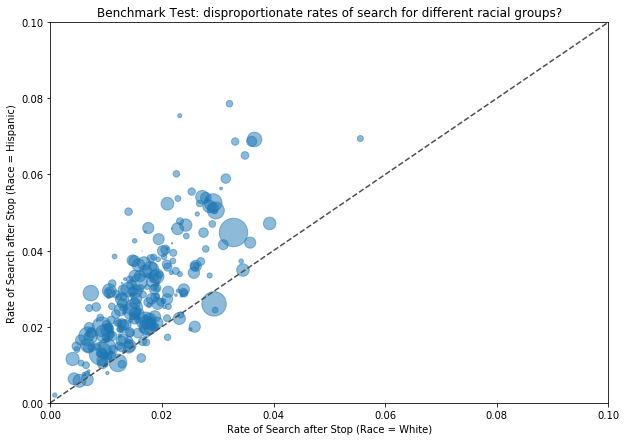

In [52]:
plt.figure(figsize=(10,7))


plt.scatter(wsHRvals, hsHRvals, alpha = .5, s=sizesS)
plt.xlim([0,.1])
plt.ylim([0,.1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Search after Stop (Race = White)")
plt.ylabel("Rate of Search after Stop (Race = Hispanic)")
plt.title("Benchmark Test: disproportionate rates of search for different racial groups?")

Interpretation: hispanic drivers are searched at higher rates than white drivers in most counties in Texas. While not conclusive evidence of discrimination it does suggest a difference in how police treat hispanic and white drivers after a stop - namely, that Texas State troopers are more likely to search hispanic drivers than white drivers.

Text(0.5,1,'Outcome Test: disproportionate outcomes for different racial groups based on success of searches?')

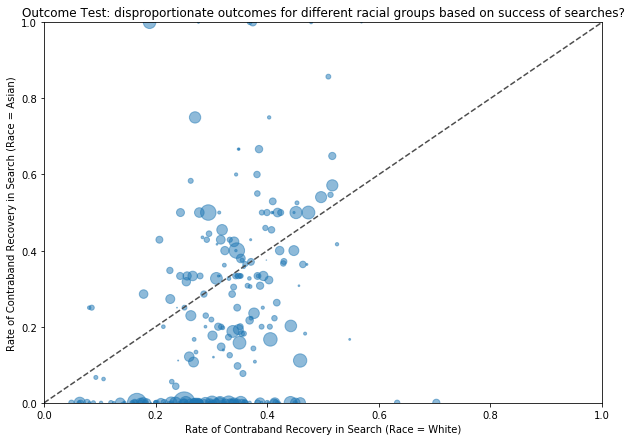

In [53]:
plt.figure(figsize=(10,7))


plt.scatter(wcHRvals, acHRvals, alpha = .5, s=sizesC)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Contraband Recovery in Search (Race = White)")
plt.ylabel("Rate of Contraband Recovery in Search (Race = Asian)")
plt.title("Outcome Test: disproportionate outcomes for different racial groups based on success of searches?")

Interpretation: a significant portion of counties recovered no contraband in searches of asian drivers, suggesting a small number of searches conducted on asian drivers in some counties. The lack of samples makes it hard to determine whether or not there is significantly different treatment by Texas state troopers of asian and white drivers.

Text(0.5,1,'Benchmark Test: disproportionate rates of search for different racial groups?')

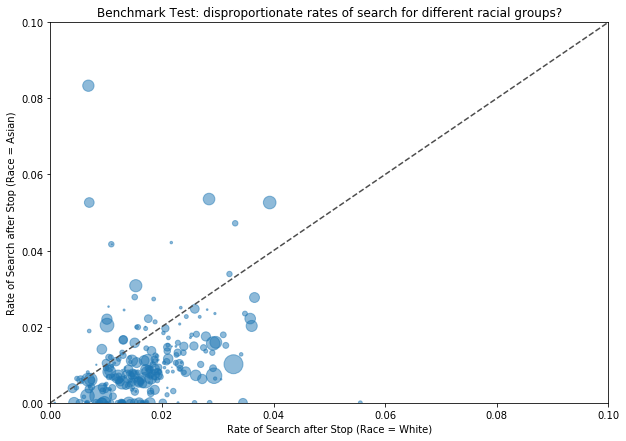

In [54]:
plt.figure(figsize=(10,7))


plt.scatter(wsHRvals, asHRvals, alpha = .5, s=sizesC)
plt.xlim([0,.1])
plt.ylim([0,.1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Search after Stop (Race = White)")
plt.ylabel("Rate of Search after Stop (Race = Asian)")
plt.title("Benchmark Test: disproportionate rates of search for different racial groups?")

Interpretation: It does seem that white drivers are searched at higher rates than asian drivers, but again, the issue of a small sample size makes it hard to conclude definitively whether Texas state troopers treat asian and white drivers.

In [24]:
#Sorting to find hit rate outliers
import operator
sorted(whitecontrabandHR.items(), key=operator.itemgetter(1))

[('Hansford County', 0),
 ('Jim Hogg County', 0.049122807017543901),
 ('Maverick County', 0.062880324543610588),
 ('Brooks County', 0.063965884861407196),
 ('Willacy County', 0.065546218487394947),
 ('Lipscomb County', 0.076923076923076872),
 ('Kenedy County', 0.080924855491329439),
 ('Dimmit County', 0.08108108108108103),
 ('La Salle County', 0.08536585365853655),
 ('Zapata County', 0.088397790055248615),
 ('Webb County', 0.092783505154639179),
 ('Starr County', 0.10211591536338549),
 ('Hidalgo County', 0.10657894736842111),
 ('Val Verde County', 0.11984536082474229),
 ('Kleberg County', 0.125),
 ('Briscoe County', 0.13636363636363635),
 ('Kinney County', 0.13856812933025409),
 ('Aransas County', 0.14334470989761094),
 ('McCulloch County', 0.14388489208633093),
 ('Kent County', 0.15789473684210531),
 ('Live Oak County', 0.16129032258064513),
 ('Mason County', 0.16233766233766234),
 ('Ochiltree County', 0.16296296296296298),
 ('Zavala County', 0.16640746500777603),
 ('Frio County', 0.1